In [2]:
!pip install transformers==3.4.0

     |████████████████████████████████| 1.3 MB 403 kB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 6.3 MB/s eta 0:00:01
ERROR: allennlp 1.0.0 has requirement transformers<2.12,>=2.9, but you'll have transformers 3.4.0 which is incompatible.
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.7.0
    Uninstalling tokenizers-0.7.0:
      Successfully uninstalled tokenizers-0.7.0
  Attempting uninstall: transformers
    Found existing installation: transformers 2.11.0
    Uninstalling transformers-2.11.0:
      Successfully uninstalled transformers-2.11.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.layers.core import Dense, Dropout
import transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast, RobertaTokenizer, RobertaModel, TFXLMRobertaModel
from transformers import AutoTokenizer,TFXLMRobertaModel, XLMRobertaModel,XLMTokenizer,XLMWithLMHeadModel
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
import matplotlib.pyplot as plt
import numpy as np

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
transformers.__version__

'3.4.0'

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

Running on TPU  grpc://10.0.0.2:8470


In [6]:
train = pd.read_csv('../input/modified/train_modified.csv')
valid = pd.read_csv('../input/modified/val_modified.csv')
test = pd.read_csv('../input/modified/test_modified.csv')

In [7]:
xtrain, ytrain = train.Comment.values, train.Emotion.values
xvalid, yvalid = valid.Comment.values, valid.Emotion.values
xtest, ytest = test.Comment.values, test.Emotion.values

In [8]:
tokenizer = AutoTokenizer.from_pretrained("jplu/tf-xlm-roberta-base")
# tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-tlm-xnli15-1024')
max_len = 200

In [9]:
xtrain_pad = tokenizer(
    text=train['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

xvalid_pad = tokenizer(
    text=valid['Comment'].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

In [10]:
def build_model(transformer):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    sequence_output = transformer(input_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(4, activation='softmax')(cls_token)

    model = Model(inputs=input_ids, outputs=out)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(SGD(lr=1e-3), loss=loss, metrics=['accuracy'])

    return model

In [11]:
with strategy.scope():
    transformer_model = TFXLMRobertaModel.from_pretrained("jplu/tf-xlm-roberta-base")
    model = build_model(transformer_model)

Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
tfxlm_roberta_model (TFXLMRo ((None, 200, 768), (None, 278043648 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 3076      
Total params: 278,046,724
Trainable params: 278,046,724
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Batch Size 32
history = model.fit(xtrain_pad['input_ids'], ytrain,epochs=100, validation_data= (xvalid_pad['input_ids'], yvalid), batch_size=32)

Epoch 1/100


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 192001536 elements. This may consume a large amount of memory.
  num_elements)


94/94 [==============================] - ETA: 0s - accuracy: 0.3438 - loss: 1.35 - ETA: 3s - accuracy: 0.2969 - loss: 1.36 - ETA: 4s - accuracy: 0.2396 - loss: 1.38 - ETA: 4s - accuracy: 0.2734 - loss: 1.38 - ETA: 5s - accuracy: 0.2625 - loss: 1.38 - ETA: 5s - accuracy: 0.2604 - loss: 1.39 - ETA: 5s - accuracy: 0.2411 - loss: 1.39 - ETA: 5s - accuracy: 0.2422 - loss: 1.39 - ETA: 5s - accuracy: 0.2361 - loss: 1.39 - ETA: 5s - accuracy: 0.2344 - loss: 1.39 - ETA: 5s - accuracy: 0.2415 - loss: 1.39 - ETA: 5s - accuracy: 0.2526 - loss: 1.38 - ETA: 5s - accuracy: 0.2692 - loss: 1.38 - ETA: 5s - accuracy: 0.2634 - loss: 1.38 - ETA: 5s - accuracy: 0.2583 - loss: 1.38 - ETA: 5s - accuracy: 0.2480 - loss: 1.39 - ETA: 5s - accuracy: 0.2500 - loss: 1.39 - ETA: 5s - accuracy: 0.2517 - loss: 1.39 - ETA: 4s - accuracy: 0.2533 - loss: 1.39 - ETA: 4s - accuracy: 0.2531 - loss: 1.39 - ETA: 4s - accuracy: 0.2515 - loss: 1.39 - ETA: 4s - accuracy: 0.2472 - loss: 1.39 - ETA: 4s - accuracy: 0.2432 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2812 - loss: 1.37 - ETA: 3s - accuracy: 0.2344 - loss: 1.37 - ETA: 4s - accuracy: 0.2396 - loss: 1.38 - ETA: 4s - accuracy: 0.2422 - loss: 1.38 - ETA: 5s - accuracy: 0.2438 - loss: 1.38 - ETA: 5s - accuracy: 0.2396 - loss: 1.38 - ETA: 5s - accuracy: 0.2455 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2535 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2448 - loss: 1.39 - ETA: 5s - accuracy: 0.2572 - loss: 1.39 - ETA: 5s - accuracy: 0.2500 - loss: 1.39 - ETA: 5s - accuracy: 0.2604 - loss: 1.38 - ETA: 5s - accuracy: 0.2637 - loss: 1.38 - ETA: 5s - accuracy: 0.2647 - loss: 1.39 - ETA: 4s - accuracy: 0.2604 - loss: 1.39 - ETA: 4s - accuracy: 0.2599 - loss: 1.39 - ETA: 4s - accuracy: 0.2578 - loss: 1.39 - ETA: 4s - accuracy: 0.2604 - loss: 1.39 - ETA: 4s - accuracy: 0.2571 - loss: 1.39 - ETA: 4s - accuracy: 0.2636 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.1562 - loss: 1.38 - ETA: 3s - accuracy: 0.1875 - loss: 1.38 - ETA: 4s - accuracy: 0.1875 - loss: 1.38 - ETA: 4s - accuracy: 0.2031 - loss: 1.38 - ETA: 4s - accuracy: 0.2000 - loss: 1.38 - ETA: 5s - accuracy: 0.1927 - loss: 1.38 - ETA: 5s - accuracy: 0.2009 - loss: 1.38 - ETA: 5s - accuracy: 0.1953 - loss: 1.39 - ETA: 5s - accuracy: 0.2014 - loss: 1.38 - ETA: 5s - accuracy: 0.2031 - loss: 1.38 - ETA: 5s - accuracy: 0.2102 - loss: 1.38 - ETA: 5s - accuracy: 0.2135 - loss: 1.38 - ETA: 5s - accuracy: 0.2163 - loss: 1.38 - ETA: 5s - accuracy: 0.2098 - loss: 1.38 - ETA: 5s - accuracy: 0.2167 - loss: 1.38 - ETA: 5s - accuracy: 0.2227 - loss: 1.38 - ETA: 5s - accuracy: 0.2243 - loss: 1.38 - ETA: 5s - accuracy: 0.2240 - loss: 1.38 - ETA: 5s - accuracy: 0.2286 - loss: 1.38 - ETA: 4s - accuracy: 0.2328 - loss: 1.38 - ETA: 4s - accuracy: 0.2411 - loss: 1.38 - ETA: 4s - accuracy: 0.2358 - loss: 1.38 - ETA: 4s - accuracy: 0.2351 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2500 - loss: 1.38 - ETA: 3s - accuracy: 0.2656 - loss: 1.38 - ETA: 4s - accuracy: 0.2604 - loss: 1.38 - ETA: 4s - accuracy: 0.3047 - loss: 1.38 - ETA: 4s - accuracy: 0.2875 - loss: 1.38 - ETA: 5s - accuracy: 0.2760 - loss: 1.38 - ETA: 5s - accuracy: 0.2857 - loss: 1.38 - ETA: 5s - accuracy: 0.2891 - loss: 1.38 - ETA: 5s - accuracy: 0.2847 - loss: 1.38 - ETA: 5s - accuracy: 0.2719 - loss: 1.38 - ETA: 5s - accuracy: 0.2756 - loss: 1.38 - ETA: 5s - accuracy: 0.2760 - loss: 1.38 - ETA: 5s - accuracy: 0.2740 - loss: 1.38 - ETA: 5s - accuracy: 0.2723 - loss: 1.38 - ETA: 5s - accuracy: 0.2667 - loss: 1.38 - ETA: 5s - accuracy: 0.2617 - loss: 1.38 - ETA: 5s - accuracy: 0.2555 - loss: 1.38 - ETA: 5s - accuracy: 0.2552 - loss: 1.38 - ETA: 5s - accuracy: 0.2484 - loss: 1.38 - ETA: 5s - accuracy: 0.2453 - loss: 1.38 - ETA: 5s - accuracy: 0.2411 - loss: 1.38 - ETA: 5s - accuracy: 0.2443 - loss: 1.38 - ETA: 5s - accuracy: 0.2473 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.0938 - loss: 1.39 - ETA: 3s - accuracy: 0.2500 - loss: 1.38 - ETA: 4s - accuracy: 0.2292 - loss: 1.38 - ETA: 4s - accuracy: 0.2266 - loss: 1.38 - ETA: 4s - accuracy: 0.2438 - loss: 1.38 - ETA: 5s - accuracy: 0.2448 - loss: 1.38 - ETA: 5s - accuracy: 0.2679 - loss: 1.38 - ETA: 5s - accuracy: 0.2539 - loss: 1.38 - ETA: 5s - accuracy: 0.2535 - loss: 1.38 - ETA: 5s - accuracy: 0.2750 - loss: 1.38 - ETA: 5s - accuracy: 0.2727 - loss: 1.38 - ETA: 5s - accuracy: 0.2760 - loss: 1.38 - ETA: 5s - accuracy: 0.2644 - loss: 1.38 - ETA: 5s - accuracy: 0.2589 - loss: 1.38 - ETA: 5s - accuracy: 0.2667 - loss: 1.38 - ETA: 5s - accuracy: 0.2656 - loss: 1.38 - ETA: 5s - accuracy: 0.2647 - loss: 1.38 - ETA: 5s - accuracy: 0.2604 - loss: 1.38 - ETA: 5s - accuracy: 0.2582 - loss: 1.38 - ETA: 4s - accuracy: 0.2562 - loss: 1.38 - ETA: 4s - accuracy: 0.2589 - loss: 1.38 - ETA: 4s - accuracy: 0.2628 - loss: 1.38 - ETA: 4s - accuracy: 0.2582 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.1875 - loss: 1.38 - ETA: 3s - accuracy: 0.2969 - loss: 1.38 - ETA: 4s - accuracy: 0.2812 - loss: 1.38 - ETA: 4s - accuracy: 0.3125 - loss: 1.38 - ETA: 4s - accuracy: 0.2938 - loss: 1.38 - ETA: 5s - accuracy: 0.2969 - loss: 1.38 - ETA: 5s - accuracy: 0.2857 - loss: 1.38 - ETA: 5s - accuracy: 0.2930 - loss: 1.38 - ETA: 5s - accuracy: 0.2847 - loss: 1.38 - ETA: 5s - accuracy: 0.2875 - loss: 1.38 - ETA: 5s - accuracy: 0.2869 - loss: 1.38 - ETA: 5s - accuracy: 0.2786 - loss: 1.38 - ETA: 5s - accuracy: 0.2764 - loss: 1.38 - ETA: 5s - accuracy: 0.2723 - loss: 1.38 - ETA: 5s - accuracy: 0.2771 - loss: 1.38 - ETA: 5s - accuracy: 0.2715 - loss: 1.38 - ETA: 5s - accuracy: 0.2757 - loss: 1.38 - ETA: 5s - accuracy: 0.2778 - loss: 1.38 - ETA: 5s - accuracy: 0.2747 - loss: 1.38 - ETA: 4s - accuracy: 0.2719 - loss: 1.38 - ETA: 4s - accuracy: 0.2753 - loss: 1.38 - ETA: 4s - accuracy: 0.2727 - loss: 1.38 - ETA: 4s - accuracy: 0.2745 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2500 - loss: 1.38 - ETA: 3s - accuracy: 0.2344 - loss: 1.38 - ETA: 4s - accuracy: 0.2188 - loss: 1.38 - ETA: 4s - accuracy: 0.2266 - loss: 1.38 - ETA: 5s - accuracy: 0.2438 - loss: 1.38 - ETA: 5s - accuracy: 0.2448 - loss: 1.38 - ETA: 5s - accuracy: 0.2545 - loss: 1.38 - ETA: 5s - accuracy: 0.2578 - loss: 1.38 - ETA: 5s - accuracy: 0.2604 - loss: 1.38 - ETA: 5s - accuracy: 0.2781 - loss: 1.38 - ETA: 5s - accuracy: 0.2642 - loss: 1.38 - ETA: 5s - accuracy: 0.2630 - loss: 1.38 - ETA: 5s - accuracy: 0.2668 - loss: 1.38 - ETA: 5s - accuracy: 0.2679 - loss: 1.38 - ETA: 5s - accuracy: 0.2729 - loss: 1.38 - ETA: 5s - accuracy: 0.2695 - loss: 1.38 - ETA: 5s - accuracy: 0.2629 - loss: 1.38 - ETA: 5s - accuracy: 0.2674 - loss: 1.38 - ETA: 5s - accuracy: 0.2664 - loss: 1.38 - ETA: 4s - accuracy: 0.2656 - loss: 1.38 - ETA: 4s - accuracy: 0.2604 - loss: 1.38 - ETA: 4s - accuracy: 0.2599 - loss: 1.38 - ETA: 4s - accuracy: 0.2595 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2188 - loss: 1.38 - ETA: 3s - accuracy: 0.2344 - loss: 1.38 - ETA: 4s - accuracy: 0.1875 - loss: 1.38 - ETA: 4s - accuracy: 0.2188 - loss: 1.38 - ETA: 5s - accuracy: 0.2438 - loss: 1.38 - ETA: 5s - accuracy: 0.2552 - loss: 1.38 - ETA: 5s - accuracy: 0.2455 - loss: 1.38 - ETA: 5s - accuracy: 0.2383 - loss: 1.38 - ETA: 5s - accuracy: 0.2535 - loss: 1.38 - ETA: 5s - accuracy: 0.2469 - loss: 1.38 - ETA: 5s - accuracy: 0.2585 - loss: 1.38 - ETA: 5s - accuracy: 0.2552 - loss: 1.38 - ETA: 5s - accuracy: 0.2596 - loss: 1.38 - ETA: 5s - accuracy: 0.2612 - loss: 1.38 - ETA: 5s - accuracy: 0.2625 - loss: 1.38 - ETA: 5s - accuracy: 0.2539 - loss: 1.38 - ETA: 5s - accuracy: 0.2482 - loss: 1.38 - ETA: 5s - accuracy: 0.2517 - loss: 1.38 - ETA: 5s - accuracy: 0.2484 - loss: 1.38 - ETA: 4s - accuracy: 0.2516 - loss: 1.38 - ETA: 4s - accuracy: 0.2574 - loss: 1.38 - ETA: 4s - accuracy: 0.2614 - loss: 1.38 - ETA: 4s - accuracy: 0.2622 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2812 - loss: 1.38 - ETA: 3s - accuracy: 0.2500 - loss: 1.38 - ETA: 4s - accuracy: 0.2292 - loss: 1.38 - ETA: 4s - accuracy: 0.2266 - loss: 1.38 - ETA: 5s - accuracy: 0.2250 - loss: 1.38 - ETA: 5s - accuracy: 0.2448 - loss: 1.38 - ETA: 5s - accuracy: 0.2545 - loss: 1.38 - ETA: 5s - accuracy: 0.2617 - loss: 1.38 - ETA: 5s - accuracy: 0.2639 - loss: 1.38 - ETA: 5s - accuracy: 0.2688 - loss: 1.38 - ETA: 5s - accuracy: 0.2614 - loss: 1.38 - ETA: 5s - accuracy: 0.2656 - loss: 1.38 - ETA: 5s - accuracy: 0.2596 - loss: 1.38 - ETA: 5s - accuracy: 0.2545 - loss: 1.38 - ETA: 5s - accuracy: 0.2604 - loss: 1.38 - ETA: 5s - accuracy: 0.2520 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2552 - loss: 1.38 - ETA: 5s - accuracy: 0.2533 - loss: 1.38 - ETA: 5s - accuracy: 0.2531 - loss: 1.38 - ETA: 5s - accuracy: 0.2589 - loss: 1.38 - ETA: 5s - accuracy: 0.2642 - loss: 1.38 - ETA: 5s - accuracy: 0.2609 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2500 - loss: 1.38 - ETA: 3s - accuracy: 0.2031 - loss: 1.38 - ETA: 4s - accuracy: 0.1875 - loss: 1.38 - ETA: 4s - accuracy: 0.2188 - loss: 1.38 - ETA: 5s - accuracy: 0.2313 - loss: 1.38 - ETA: 5s - accuracy: 0.2604 - loss: 1.38 - ETA: 5s - accuracy: 0.2545 - loss: 1.38 - ETA: 5s - accuracy: 0.2695 - loss: 1.38 - ETA: 5s - accuracy: 0.2569 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2596 - loss: 1.38 - ETA: 5s - accuracy: 0.2634 - loss: 1.38 - ETA: 5s - accuracy: 0.2646 - loss: 1.38 - ETA: 5s - accuracy: 0.2656 - loss: 1.38 - ETA: 5s - accuracy: 0.2574 - loss: 1.38 - ETA: 5s - accuracy: 0.2587 - loss: 1.38 - ETA: 5s - accuracy: 0.2582 - loss: 1.38 - ETA: 5s - accuracy: 0.2547 - loss: 1.38 - ETA: 5s - accuracy: 0.2530 - loss: 1.38 - ETA: 4s - accuracy: 0.2571 - loss: 1.38 - ETA: 4s - accuracy: 0.2582 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.3750 - loss: 1.37 - ETA: 3s - accuracy: 0.3438 - loss: 1.38 - ETA: 6s - accuracy: 0.3021 - loss: 1.38 - ETA: 7s - accuracy: 0.2891 - loss: 1.38 - ETA: 6s - accuracy: 0.2750 - loss: 1.38 - ETA: 6s - accuracy: 0.2812 - loss: 1.38 - ETA: 6s - accuracy: 0.2723 - loss: 1.38 - ETA: 6s - accuracy: 0.2734 - loss: 1.38 - ETA: 6s - accuracy: 0.2812 - loss: 1.38 - ETA: 6s - accuracy: 0.2656 - loss: 1.38 - ETA: 6s - accuracy: 0.2585 - loss: 1.38 - ETA: 6s - accuracy: 0.2604 - loss: 1.38 - ETA: 5s - accuracy: 0.2692 - loss: 1.38 - ETA: 5s - accuracy: 0.2656 - loss: 1.38 - ETA: 5s - accuracy: 0.2583 - loss: 1.38 - ETA: 5s - accuracy: 0.2539 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2516 - loss: 1.38 - ETA: 5s - accuracy: 0.2516 - loss: 1.38 - ETA: 5s - accuracy: 0.2485 - loss: 1.38 - ETA: 5s - accuracy: 0.2557 - loss: 1.38 - ETA: 5s - accuracy: 0.2609 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2812 - loss: 1.38 - ETA: 3s - accuracy: 0.2969 - loss: 1.38 - ETA: 4s - accuracy: 0.3229 - loss: 1.38 - ETA: 4s - accuracy: 0.2969 - loss: 1.38 - ETA: 5s - accuracy: 0.2812 - loss: 1.38 - ETA: 5s - accuracy: 0.2760 - loss: 1.38 - ETA: 5s - accuracy: 0.2812 - loss: 1.38 - ETA: 5s - accuracy: 0.2617 - loss: 1.38 - ETA: 5s - accuracy: 0.2674 - loss: 1.38 - ETA: 5s - accuracy: 0.2562 - loss: 1.38 - ETA: 5s - accuracy: 0.2557 - loss: 1.38 - ETA: 5s - accuracy: 0.2552 - loss: 1.38 - ETA: 5s - accuracy: 0.2596 - loss: 1.38 - ETA: 5s - accuracy: 0.2634 - loss: 1.38 - ETA: 5s - accuracy: 0.2521 - loss: 1.38 - ETA: 5s - accuracy: 0.2617 - loss: 1.38 - ETA: 5s - accuracy: 0.2629 - loss: 1.38 - ETA: 5s - accuracy: 0.2587 - loss: 1.38 - ETA: 5s - accuracy: 0.2599 - loss: 1.38 - ETA: 5s - accuracy: 0.2641 - loss: 1.38 - ETA: 5s - accuracy: 0.2604 - loss: 1.38 - ETA: 4s - accuracy: 0.2656 - loss: 1.38 - ETA: 4s - accuracy: 0.2595 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2188 - loss: 1.38 - ETA: 3s - accuracy: 0.2344 - loss: 1.38 - ETA: 4s - accuracy: 0.1667 - loss: 1.38 - ETA: 4s - accuracy: 0.2031 - loss: 1.38 - ETA: 4s - accuracy: 0.2062 - loss: 1.38 - ETA: 5s - accuracy: 0.2240 - loss: 1.38 - ETA: 5s - accuracy: 0.2321 - loss: 1.38 - ETA: 5s - accuracy: 0.2383 - loss: 1.38 - ETA: 5s - accuracy: 0.2465 - loss: 1.38 - ETA: 5s - accuracy: 0.2562 - loss: 1.38 - ETA: 6s - accuracy: 0.2528 - loss: 1.38 - ETA: 6s - accuracy: 0.2526 - loss: 1.38 - ETA: 6s - accuracy: 0.2452 - loss: 1.38 - ETA: 6s - accuracy: 0.2388 - loss: 1.38 - ETA: 5s - accuracy: 0.2417 - loss: 1.38 - ETA: 5s - accuracy: 0.2520 - loss: 1.38 - ETA: 5s - accuracy: 0.2482 - loss: 1.38 - ETA: 5s - accuracy: 0.2431 - loss: 1.38 - ETA: 5s - accuracy: 0.2451 - loss: 1.38 - ETA: 5s - accuracy: 0.2469 - loss: 1.38 - ETA: 5s - accuracy: 0.2455 - loss: 1.38 - ETA: 5s - accuracy: 0.2457 - loss: 1.38 - ETA: 5s - accuracy: 0.2473 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2188 - loss: 1.38 - ETA: 3s - accuracy: 0.2031 - loss: 1.38 - ETA: 4s - accuracy: 0.2083 - loss: 1.38 - ETA: 4s - accuracy: 0.2188 - loss: 1.38 - ETA: 5s - accuracy: 0.2250 - loss: 1.38 - ETA: 5s - accuracy: 0.2240 - loss: 1.38 - ETA: 5s - accuracy: 0.2411 - loss: 1.38 - ETA: 5s - accuracy: 0.2422 - loss: 1.38 - ETA: 5s - accuracy: 0.2465 - loss: 1.38 - ETA: 5s - accuracy: 0.2469 - loss: 1.38 - ETA: 5s - accuracy: 0.2443 - loss: 1.38 - ETA: 5s - accuracy: 0.2422 - loss: 1.38 - ETA: 5s - accuracy: 0.2404 - loss: 1.38 - ETA: 5s - accuracy: 0.2455 - loss: 1.38 - ETA: 5s - accuracy: 0.2396 - loss: 1.38 - ETA: 5s - accuracy: 0.2422 - loss: 1.38 - ETA: 5s - accuracy: 0.2371 - loss: 1.38 - ETA: 5s - accuracy: 0.2396 - loss: 1.38 - ETA: 5s - accuracy: 0.2385 - loss: 1.38 - ETA: 5s - accuracy: 0.2438 - loss: 1.38 - ETA: 4s - accuracy: 0.2440 - loss: 1.38 - ETA: 5s - accuracy: 0.2443 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2812 - loss: 1.38 - ETA: 3s - accuracy: 0.2812 - loss: 1.38 - ETA: 4s - accuracy: 0.2917 - loss: 1.38 - ETA: 4s - accuracy: 0.3047 - loss: 1.38 - ETA: 5s - accuracy: 0.3125 - loss: 1.38 - ETA: 5s - accuracy: 0.2917 - loss: 1.38 - ETA: 5s - accuracy: 0.2946 - loss: 1.38 - ETA: 5s - accuracy: 0.3008 - loss: 1.38 - ETA: 5s - accuracy: 0.2986 - loss: 1.38 - ETA: 5s - accuracy: 0.3031 - loss: 1.38 - ETA: 5s - accuracy: 0.2983 - loss: 1.38 - ETA: 5s - accuracy: 0.3047 - loss: 1.38 - ETA: 5s - accuracy: 0.3029 - loss: 1.38 - ETA: 5s - accuracy: 0.2969 - loss: 1.38 - ETA: 5s - accuracy: 0.2917 - loss: 1.38 - ETA: 5s - accuracy: 0.2852 - loss: 1.38 - ETA: 5s - accuracy: 0.2812 - loss: 1.38 - ETA: 5s - accuracy: 0.2743 - loss: 1.38 - ETA: 5s - accuracy: 0.2681 - loss: 1.38 - ETA: 4s - accuracy: 0.2688 - loss: 1.38 - ETA: 5s - accuracy: 0.2679 - loss: 1.38 - ETA: 5s - accuracy: 0.2670 - loss: 1.38 - ETA: 5s - accuracy: 0.2636 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.3750 - loss: 1.37 - ETA: 3s - accuracy: 0.2812 - loss: 1.38 - ETA: 4s - accuracy: 0.2708 - loss: 1.38 - ETA: 4s - accuracy: 0.2812 - loss: 1.38 - ETA: 5s - accuracy: 0.2750 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2545 - loss: 1.38 - ETA: 5s - accuracy: 0.2383 - loss: 1.38 - ETA: 5s - accuracy: 0.2361 - loss: 1.38 - ETA: 5s - accuracy: 0.2313 - loss: 1.38 - ETA: 5s - accuracy: 0.2443 - loss: 1.38 - ETA: 5s - accuracy: 0.2448 - loss: 1.38 - ETA: 5s - accuracy: 0.2452 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2426 - loss: 1.38 - ETA: 5s - accuracy: 0.2431 - loss: 1.38 - ETA: 5s - accuracy: 0.2451 - loss: 1.38 - ETA: 5s - accuracy: 0.2469 - loss: 1.38 - ETA: 4s - accuracy: 0.2515 - loss: 1.38 - ETA: 4s - accuracy: 0.2514 - loss: 1.38 - ETA: 4s - accuracy: 0.2541 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2188 - loss: 1.38 - ETA: 3s - accuracy: 0.1719 - loss: 1.38 - ETA: 4s - accuracy: 0.1979 - loss: 1.38 - ETA: 4s - accuracy: 0.2031 - loss: 1.38 - ETA: 5s - accuracy: 0.2375 - loss: 1.38 - ETA: 5s - accuracy: 0.2396 - loss: 1.38 - ETA: 5s - accuracy: 0.2277 - loss: 1.38 - ETA: 5s - accuracy: 0.2422 - loss: 1.38 - ETA: 5s - accuracy: 0.2292 - loss: 1.38 - ETA: 5s - accuracy: 0.2406 - loss: 1.38 - ETA: 5s - accuracy: 0.2585 - loss: 1.38 - ETA: 5s - accuracy: 0.2448 - loss: 1.38 - ETA: 5s - accuracy: 0.2476 - loss: 1.38 - ETA: 5s - accuracy: 0.2567 - loss: 1.38 - ETA: 5s - accuracy: 0.2563 - loss: 1.38 - ETA: 5s - accuracy: 0.2578 - loss: 1.38 - ETA: 5s - accuracy: 0.2555 - loss: 1.38 - ETA: 5s - accuracy: 0.2535 - loss: 1.38 - ETA: 5s - accuracy: 0.2582 - loss: 1.38 - ETA: 4s - accuracy: 0.2547 - loss: 1.38 - ETA: 4s - accuracy: 0.2500 - loss: 1.38 - ETA: 4s - accuracy: 0.2457 - loss: 1.38 - ETA: 4s - accuracy: 0.2432 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2812 - loss: 1.38 - ETA: 3s - accuracy: 0.2031 - loss: 1.38 - ETA: 4s - accuracy: 0.1979 - loss: 1.38 - ETA: 4s - accuracy: 0.2188 - loss: 1.38 - ETA: 4s - accuracy: 0.2062 - loss: 1.38 - ETA: 5s - accuracy: 0.2344 - loss: 1.38 - ETA: 5s - accuracy: 0.2321 - loss: 1.38 - ETA: 5s - accuracy: 0.2383 - loss: 1.38 - ETA: 5s - accuracy: 0.2569 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2585 - loss: 1.38 - ETA: 5s - accuracy: 0.2656 - loss: 1.38 - ETA: 5s - accuracy: 0.2620 - loss: 1.38 - ETA: 5s - accuracy: 0.2612 - loss: 1.38 - ETA: 5s - accuracy: 0.2563 - loss: 1.38 - ETA: 5s - accuracy: 0.2617 - loss: 1.38 - ETA: 5s - accuracy: 0.2647 - loss: 1.38 - ETA: 5s - accuracy: 0.2639 - loss: 1.38 - ETA: 5s - accuracy: 0.2615 - loss: 1.38 - ETA: 4s - accuracy: 0.2656 - loss: 1.38 - ETA: 4s - accuracy: 0.2693 - loss: 1.38 - ETA: 4s - accuracy: 0.2713 - loss: 1.38 - ETA: 4s - accuracy: 0.2636 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2500 - loss: 1.38 - ETA: 3s - accuracy: 0.2031 - loss: 1.38 - ETA: 4s - accuracy: 0.2292 - loss: 1.38 - ETA: 4s - accuracy: 0.2422 - loss: 1.38 - ETA: 4s - accuracy: 0.2375 - loss: 1.38 - ETA: 5s - accuracy: 0.2240 - loss: 1.38 - ETA: 5s - accuracy: 0.2232 - loss: 1.38 - ETA: 5s - accuracy: 0.2266 - loss: 1.38 - ETA: 5s - accuracy: 0.2222 - loss: 1.38 - ETA: 5s - accuracy: 0.2281 - loss: 1.38 - ETA: 5s - accuracy: 0.2443 - loss: 1.38 - ETA: 5s - accuracy: 0.2526 - loss: 1.38 - ETA: 5s - accuracy: 0.2524 - loss: 1.38 - ETA: 5s - accuracy: 0.2522 - loss: 1.38 - ETA: 5s - accuracy: 0.2542 - loss: 1.38 - ETA: 5s - accuracy: 0.2539 - loss: 1.38 - ETA: 5s - accuracy: 0.2555 - loss: 1.38 - ETA: 5s - accuracy: 0.2552 - loss: 1.38 - ETA: 4s - accuracy: 0.2549 - loss: 1.38 - ETA: 4s - accuracy: 0.2578 - loss: 1.38 - ETA: 4s - accuracy: 0.2589 - loss: 1.38 - ETA: 4s - accuracy: 0.2557 - loss: 1.38 - ETA: 5s - accuracy: 0.2568 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.4062 - loss: 1.38 - ETA: 3s - accuracy: 0.2812 - loss: 1.38 - ETA: 4s - accuracy: 0.3021 - loss: 1.38 - ETA: 4s - accuracy: 0.2891 - loss: 1.38 - ETA: 5s - accuracy: 0.2938 - loss: 1.38 - ETA: 5s - accuracy: 0.3177 - loss: 1.38 - ETA: 5s - accuracy: 0.3125 - loss: 1.38 - ETA: 5s - accuracy: 0.2969 - loss: 1.38 - ETA: 5s - accuracy: 0.2951 - loss: 1.38 - ETA: 5s - accuracy: 0.2875 - loss: 1.38 - ETA: 5s - accuracy: 0.2784 - loss: 1.38 - ETA: 5s - accuracy: 0.2656 - loss: 1.38 - ETA: 5s - accuracy: 0.2644 - loss: 1.38 - ETA: 5s - accuracy: 0.2589 - loss: 1.38 - ETA: 5s - accuracy: 0.2563 - loss: 1.38 - ETA: 5s - accuracy: 0.2598 - loss: 1.38 - ETA: 5s - accuracy: 0.2592 - loss: 1.38 - ETA: 5s - accuracy: 0.2483 - loss: 1.38 - ETA: 4s - accuracy: 0.2451 - loss: 1.38 - ETA: 4s - accuracy: 0.2438 - loss: 1.38 - ETA: 4s - accuracy: 0.2396 - loss: 1.38 - ETA: 4s - accuracy: 0.2443 - loss: 1.38 - ETA: 4s - accuracy: 0.2554 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2812 - loss: 1.38 - ETA: 3s - accuracy: 0.2656 - loss: 1.38 - ETA: 4s - accuracy: 0.2292 - loss: 1.38 - ETA: 4s - accuracy: 0.2344 - loss: 1.38 - ETA: 5s - accuracy: 0.2313 - loss: 1.38 - ETA: 5s - accuracy: 0.2344 - loss: 1.38 - ETA: 5s - accuracy: 0.2455 - loss: 1.38 - ETA: 5s - accuracy: 0.2578 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2656 - loss: 1.38 - ETA: 5s - accuracy: 0.2699 - loss: 1.38 - ETA: 5s - accuracy: 0.2578 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2478 - loss: 1.38 - ETA: 5s - accuracy: 0.2542 - loss: 1.38 - ETA: 5s - accuracy: 0.2559 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2467 - loss: 1.38 - ETA: 4s - accuracy: 0.2516 - loss: 1.38 - ETA: 4s - accuracy: 0.2604 - loss: 1.38 - ETA: 4s - accuracy: 0.2642 - loss: 1.38 - ETA: 4s - accuracy: 0.2595 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.3125 - loss: 1.38 - ETA: 5s - accuracy: 0.2656 - loss: 1.38 - ETA: 7s - accuracy: 0.2500 - loss: 1.38 - ETA: 7s - accuracy: 0.2656 - loss: 1.38 - ETA: 6s - accuracy: 0.2375 - loss: 1.38 - ETA: 6s - accuracy: 0.2396 - loss: 1.38 - ETA: 6s - accuracy: 0.2545 - loss: 1.38 - ETA: 6s - accuracy: 0.2617 - loss: 1.38 - ETA: 6s - accuracy: 0.2778 - loss: 1.38 - ETA: 6s - accuracy: 0.2750 - loss: 1.38 - ETA: 6s - accuracy: 0.2784 - loss: 1.38 - ETA: 6s - accuracy: 0.2786 - loss: 1.38 - ETA: 5s - accuracy: 0.2740 - loss: 1.38 - ETA: 5s - accuracy: 0.2746 - loss: 1.38 - ETA: 5s - accuracy: 0.2688 - loss: 1.38 - ETA: 5s - accuracy: 0.2695 - loss: 1.38 - ETA: 5s - accuracy: 0.2794 - loss: 1.38 - ETA: 5s - accuracy: 0.2830 - loss: 1.38 - ETA: 5s - accuracy: 0.2796 - loss: 1.38 - ETA: 5s - accuracy: 0.2719 - loss: 1.38 - ETA: 5s - accuracy: 0.2723 - loss: 1.38 - ETA: 5s - accuracy: 0.2670 - loss: 1.38 - ETA: 5s - accuracy: 0.2622 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2188 - loss: 1.38 - ETA: 3s - accuracy: 0.2500 - loss: 1.38 - ETA: 4s - accuracy: 0.2708 - loss: 1.38 - ETA: 4s - accuracy: 0.2500 - loss: 1.38 - ETA: 4s - accuracy: 0.2625 - loss: 1.38 - ETA: 5s - accuracy: 0.2552 - loss: 1.38 - ETA: 5s - accuracy: 0.2589 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2531 - loss: 1.38 - ETA: 5s - accuracy: 0.2415 - loss: 1.38 - ETA: 5s - accuracy: 0.2370 - loss: 1.38 - ETA: 5s - accuracy: 0.2452 - loss: 1.38 - ETA: 5s - accuracy: 0.2478 - loss: 1.38 - ETA: 5s - accuracy: 0.2563 - loss: 1.38 - ETA: 5s - accuracy: 0.2559 - loss: 1.38 - ETA: 5s - accuracy: 0.2537 - loss: 1.38 - ETA: 5s - accuracy: 0.2535 - loss: 1.38 - ETA: 4s - accuracy: 0.2516 - loss: 1.38 - ETA: 4s - accuracy: 0.2547 - loss: 1.38 - ETA: 4s - accuracy: 0.2500 - loss: 1.38 - ETA: 4s - accuracy: 0.2543 - loss: 1.38 - ETA: 4s - accuracy: 0.2486 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2500 - loss: 1.37 - ETA: 3s - accuracy: 0.2812 - loss: 1.38 - ETA: 4s - accuracy: 0.2396 - loss: 1.38 - ETA: 4s - accuracy: 0.2656 - loss: 1.38 - ETA: 4s - accuracy: 0.2562 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2545 - loss: 1.38 - ETA: 5s - accuracy: 0.2578 - loss: 1.38 - ETA: 5s - accuracy: 0.2743 - loss: 1.38 - ETA: 5s - accuracy: 0.2750 - loss: 1.38 - ETA: 5s - accuracy: 0.2670 - loss: 1.38 - ETA: 5s - accuracy: 0.2708 - loss: 1.38 - ETA: 5s - accuracy: 0.2692 - loss: 1.38 - ETA: 5s - accuracy: 0.2768 - loss: 1.38 - ETA: 5s - accuracy: 0.2771 - loss: 1.38 - ETA: 5s - accuracy: 0.2832 - loss: 1.38 - ETA: 5s - accuracy: 0.2757 - loss: 1.38 - ETA: 5s - accuracy: 0.2760 - loss: 1.38 - ETA: 4s - accuracy: 0.2780 - loss: 1.38 - ETA: 4s - accuracy: 0.2812 - loss: 1.38 - ETA: 4s - accuracy: 0.2738 - loss: 1.38 - ETA: 4s - accuracy: 0.2727 - loss: 1.38 - ETA: 4s - accuracy: 0.2704 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2812 - loss: 1.38 - ETA: 3s - accuracy: 0.2656 - loss: 1.38 - ETA: 4s - accuracy: 0.2500 - loss: 1.38 - ETA: 4s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2313 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2634 - loss: 1.38 - ETA: 5s - accuracy: 0.2578 - loss: 1.38 - ETA: 5s - accuracy: 0.2674 - loss: 1.38 - ETA: 5s - accuracy: 0.2688 - loss: 1.38 - ETA: 5s - accuracy: 0.2756 - loss: 1.38 - ETA: 5s - accuracy: 0.2734 - loss: 1.38 - ETA: 5s - accuracy: 0.2788 - loss: 1.38 - ETA: 5s - accuracy: 0.2746 - loss: 1.38 - ETA: 5s - accuracy: 0.2729 - loss: 1.38 - ETA: 5s - accuracy: 0.2715 - loss: 1.38 - ETA: 5s - accuracy: 0.2794 - loss: 1.38 - ETA: 5s - accuracy: 0.2778 - loss: 1.38 - ETA: 4s - accuracy: 0.2796 - loss: 1.38 - ETA: 4s - accuracy: 0.2781 - loss: 1.38 - ETA: 4s - accuracy: 0.2798 - loss: 1.38 - ETA: 4s - accuracy: 0.2741 - loss: 1.38 - ETA: 4s - accuracy: 0.2731 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.1875 - loss: 1.38 - ETA: 3s - accuracy: 0.2344 - loss: 1.38 - ETA: 4s - accuracy: 0.2292 - loss: 1.38 - ETA: 4s - accuracy: 0.2266 - loss: 1.38 - ETA: 4s - accuracy: 0.2250 - loss: 1.38 - ETA: 5s - accuracy: 0.2240 - loss: 1.38 - ETA: 5s - accuracy: 0.2277 - loss: 1.38 - ETA: 5s - accuracy: 0.2227 - loss: 1.38 - ETA: 5s - accuracy: 0.2431 - loss: 1.38 - ETA: 5s - accuracy: 0.2406 - loss: 1.38 - ETA: 5s - accuracy: 0.2528 - loss: 1.38 - ETA: 5s - accuracy: 0.2604 - loss: 1.38 - ETA: 5s - accuracy: 0.2644 - loss: 1.38 - ETA: 5s - accuracy: 0.2612 - loss: 1.38 - ETA: 5s - accuracy: 0.2667 - loss: 1.38 - ETA: 5s - accuracy: 0.2617 - loss: 1.38 - ETA: 5s - accuracy: 0.2647 - loss: 1.38 - ETA: 5s - accuracy: 0.2622 - loss: 1.38 - ETA: 5s - accuracy: 0.2664 - loss: 1.38 - ETA: 4s - accuracy: 0.2656 - loss: 1.38 - ETA: 4s - accuracy: 0.2634 - loss: 1.38 - ETA: 4s - accuracy: 0.2670 - loss: 1.38 - ETA: 4s - accuracy: 0.2690 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.3125 - loss: 1.38 - ETA: 3s - accuracy: 0.2969 - loss: 1.38 - ETA: 4s - accuracy: 0.3333 - loss: 1.38 - ETA: 4s - accuracy: 0.3203 - loss: 1.38 - ETA: 5s - accuracy: 0.3250 - loss: 1.38 - ETA: 5s - accuracy: 0.3021 - loss: 1.38 - ETA: 5s - accuracy: 0.2946 - loss: 1.38 - ETA: 5s - accuracy: 0.2930 - loss: 1.38 - ETA: 5s - accuracy: 0.2708 - loss: 1.38 - ETA: 6s - accuracy: 0.2719 - loss: 1.38 - ETA: 6s - accuracy: 0.2784 - loss: 1.38 - ETA: 6s - accuracy: 0.2760 - loss: 1.38 - ETA: 6s - accuracy: 0.2764 - loss: 1.38 - ETA: 6s - accuracy: 0.2746 - loss: 1.38 - ETA: 6s - accuracy: 0.2708 - loss: 1.38 - ETA: 5s - accuracy: 0.2656 - loss: 1.38 - ETA: 5s - accuracy: 0.2647 - loss: 1.38 - ETA: 5s - accuracy: 0.2639 - loss: 1.38 - ETA: 5s - accuracy: 0.2714 - loss: 1.38 - ETA: 5s - accuracy: 0.2641 - loss: 1.38 - ETA: 5s - accuracy: 0.2664 - loss: 1.38 - ETA: 5s - accuracy: 0.2685 - loss: 1.38 - ETA: 5s - accuracy: 0.2690 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.3125 - loss: 1.37 - ETA: 3s - accuracy: 0.2500 - loss: 1.38 - ETA: 4s - accuracy: 0.2292 - loss: 1.38 - ETA: 4s - accuracy: 0.2188 - loss: 1.38 - ETA: 5s - accuracy: 0.2250 - loss: 1.38 - ETA: 5s - accuracy: 0.2396 - loss: 1.38 - ETA: 5s - accuracy: 0.2366 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2396 - loss: 1.38 - ETA: 5s - accuracy: 0.2562 - loss: 1.38 - ETA: 5s - accuracy: 0.2841 - loss: 1.38 - ETA: 5s - accuracy: 0.2786 - loss: 1.38 - ETA: 5s - accuracy: 0.2837 - loss: 1.38 - ETA: 5s - accuracy: 0.2790 - loss: 1.38 - ETA: 5s - accuracy: 0.2854 - loss: 1.38 - ETA: 5s - accuracy: 0.2793 - loss: 1.38 - ETA: 5s - accuracy: 0.2794 - loss: 1.38 - ETA: 5s - accuracy: 0.2760 - loss: 1.38 - ETA: 5s - accuracy: 0.2780 - loss: 1.38 - ETA: 5s - accuracy: 0.2750 - loss: 1.38 - ETA: 4s - accuracy: 0.2783 - loss: 1.38 - ETA: 4s - accuracy: 0.2827 - loss: 1.38 - ETA: 4s - accuracy: 0.2826 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.4062 - loss: 1.37 - ETA: 3s - accuracy: 0.2969 - loss: 1.37 - ETA: 4s - accuracy: 0.2917 - loss: 1.38 - ETA: 4s - accuracy: 0.2656 - loss: 1.38 - ETA: 5s - accuracy: 0.2625 - loss: 1.38 - ETA: 5s - accuracy: 0.2708 - loss: 1.38 - ETA: 5s - accuracy: 0.2545 - loss: 1.38 - ETA: 5s - accuracy: 0.2578 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2562 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2526 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2522 - loss: 1.38 - ETA: 5s - accuracy: 0.2667 - loss: 1.38 - ETA: 5s - accuracy: 0.2676 - loss: 1.38 - ETA: 5s - accuracy: 0.2721 - loss: 1.38 - ETA: 5s - accuracy: 0.2795 - loss: 1.38 - ETA: 5s - accuracy: 0.2812 - loss: 1.38 - ETA: 4s - accuracy: 0.2875 - loss: 1.38 - ETA: 4s - accuracy: 0.2857 - loss: 1.38 - ETA: 4s - accuracy: 0.2841 - loss: 1.38 - ETA: 4s - accuracy: 0.2867 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.1875 - loss: 1.38 - ETA: 3s - accuracy: 0.2812 - loss: 1.38 - ETA: 4s - accuracy: 0.2500 - loss: 1.38 - ETA: 4s - accuracy: 0.2266 - loss: 1.38 - ETA: 5s - accuracy: 0.2562 - loss: 1.38 - ETA: 5s - accuracy: 0.2708 - loss: 1.38 - ETA: 5s - accuracy: 0.2768 - loss: 1.38 - ETA: 5s - accuracy: 0.2773 - loss: 1.38 - ETA: 5s - accuracy: 0.2708 - loss: 1.38 - ETA: 5s - accuracy: 0.2562 - loss: 1.38 - ETA: 5s - accuracy: 0.2585 - loss: 1.38 - ETA: 5s - accuracy: 0.2682 - loss: 1.38 - ETA: 5s - accuracy: 0.2596 - loss: 1.38 - ETA: 5s - accuracy: 0.2522 - loss: 1.38 - ETA: 5s - accuracy: 0.2521 - loss: 1.38 - ETA: 5s - accuracy: 0.2559 - loss: 1.38 - ETA: 5s - accuracy: 0.2482 - loss: 1.38 - ETA: 5s - accuracy: 0.2552 - loss: 1.38 - ETA: 5s - accuracy: 0.2599 - loss: 1.38 - ETA: 5s - accuracy: 0.2594 - loss: 1.38 - ETA: 4s - accuracy: 0.2574 - loss: 1.38 - ETA: 4s - accuracy: 0.2628 - loss: 1.38 - ETA: 4s - accuracy: 0.2636 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2500 - loss: 1.38 - ETA: 3s - accuracy: 0.3125 - loss: 1.38 - ETA: 4s - accuracy: 0.3021 - loss: 1.38 - ETA: 4s - accuracy: 0.2891 - loss: 1.38 - ETA: 4s - accuracy: 0.2688 - loss: 1.38 - ETA: 5s - accuracy: 0.2917 - loss: 1.38 - ETA: 5s - accuracy: 0.2634 - loss: 1.38 - ETA: 5s - accuracy: 0.2656 - loss: 1.38 - ETA: 5s - accuracy: 0.2535 - loss: 1.38 - ETA: 5s - accuracy: 0.2656 - loss: 1.38 - ETA: 5s - accuracy: 0.2756 - loss: 1.38 - ETA: 5s - accuracy: 0.2708 - loss: 1.38 - ETA: 5s - accuracy: 0.2837 - loss: 1.38 - ETA: 5s - accuracy: 0.2879 - loss: 1.38 - ETA: 5s - accuracy: 0.2896 - loss: 1.38 - ETA: 5s - accuracy: 0.2949 - loss: 1.38 - ETA: 5s - accuracy: 0.3033 - loss: 1.38 - ETA: 5s - accuracy: 0.3056 - loss: 1.37 - ETA: 5s - accuracy: 0.2977 - loss: 1.38 - ETA: 5s - accuracy: 0.2938 - loss: 1.38 - ETA: 4s - accuracy: 0.2976 - loss: 1.38 - ETA: 4s - accuracy: 0.3040 - loss: 1.38 - ETA: 4s - accuracy: 0.2989 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2812 - loss: 1.38 - ETA: 3s - accuracy: 0.2656 - loss: 1.38 - ETA: 4s - accuracy: 0.2604 - loss: 1.38 - ETA: 4s - accuracy: 0.2344 - loss: 1.38 - ETA: 4s - accuracy: 0.2438 - loss: 1.38 - ETA: 5s - accuracy: 0.2552 - loss: 1.38 - ETA: 6s - accuracy: 0.2723 - loss: 1.38 - ETA: 6s - accuracy: 0.2734 - loss: 1.37 - ETA: 6s - accuracy: 0.2847 - loss: 1.37 - ETA: 6s - accuracy: 0.2750 - loss: 1.37 - ETA: 6s - accuracy: 0.2642 - loss: 1.38 - ETA: 6s - accuracy: 0.2604 - loss: 1.38 - ETA: 6s - accuracy: 0.2524 - loss: 1.38 - ETA: 6s - accuracy: 0.2567 - loss: 1.38 - ETA: 5s - accuracy: 0.2521 - loss: 1.38 - ETA: 5s - accuracy: 0.2539 - loss: 1.38 - ETA: 5s - accuracy: 0.2555 - loss: 1.38 - ETA: 5s - accuracy: 0.2639 - loss: 1.38 - ETA: 5s - accuracy: 0.2599 - loss: 1.38 - ETA: 5s - accuracy: 0.2578 - loss: 1.38 - ETA: 5s - accuracy: 0.2560 - loss: 1.38 - ETA: 5s - accuracy: 0.2585 - loss: 1.38 - ETA: 5s - accuracy: 0.2622 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.3438 - loss: 1.38 - ETA: 3s - accuracy: 0.3125 - loss: 1.38 - ETA: 4s - accuracy: 0.3542 - loss: 1.37 - ETA: 4s - accuracy: 0.3516 - loss: 1.37 - ETA: 5s - accuracy: 0.3500 - loss: 1.37 - ETA: 5s - accuracy: 0.3281 - loss: 1.37 - ETA: 5s - accuracy: 0.3125 - loss: 1.37 - ETA: 5s - accuracy: 0.3242 - loss: 1.37 - ETA: 5s - accuracy: 0.3160 - loss: 1.37 - ETA: 5s - accuracy: 0.3125 - loss: 1.37 - ETA: 5s - accuracy: 0.3125 - loss: 1.37 - ETA: 5s - accuracy: 0.3099 - loss: 1.37 - ETA: 5s - accuracy: 0.2957 - loss: 1.37 - ETA: 5s - accuracy: 0.2902 - loss: 1.37 - ETA: 5s - accuracy: 0.2938 - loss: 1.37 - ETA: 5s - accuracy: 0.2871 - loss: 1.37 - ETA: 5s - accuracy: 0.2849 - loss: 1.37 - ETA: 5s - accuracy: 0.2812 - loss: 1.38 - ETA: 5s - accuracy: 0.2862 - loss: 1.38 - ETA: 4s - accuracy: 0.2859 - loss: 1.38 - ETA: 4s - accuracy: 0.2812 - loss: 1.38 - ETA: 4s - accuracy: 0.2855 - loss: 1.38 - ETA: 4s - accuracy: 0.2826 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.1875 - loss: 1.36 - ETA: 3s - accuracy: 0.2656 - loss: 1.36 - ETA: 4s - accuracy: 0.2604 - loss: 1.36 - ETA: 4s - accuracy: 0.2734 - loss: 1.37 - ETA: 4s - accuracy: 0.2875 - loss: 1.37 - ETA: 5s - accuracy: 0.2760 - loss: 1.37 - ETA: 5s - accuracy: 0.2812 - loss: 1.37 - ETA: 5s - accuracy: 0.2734 - loss: 1.38 - ETA: 5s - accuracy: 0.2812 - loss: 1.37 - ETA: 5s - accuracy: 0.2781 - loss: 1.38 - ETA: 5s - accuracy: 0.2670 - loss: 1.38 - ETA: 5s - accuracy: 0.2734 - loss: 1.38 - ETA: 5s - accuracy: 0.2764 - loss: 1.38 - ETA: 5s - accuracy: 0.2812 - loss: 1.38 - ETA: 5s - accuracy: 0.2792 - loss: 1.38 - ETA: 5s - accuracy: 0.2832 - loss: 1.37 - ETA: 5s - accuracy: 0.2886 - loss: 1.37 - ETA: 5s - accuracy: 0.2899 - loss: 1.37 - ETA: 5s - accuracy: 0.2895 - loss: 1.37 - ETA: 4s - accuracy: 0.2953 - loss: 1.37 - ETA: 4s - accuracy: 0.2932 - loss: 1.37 - ETA: 4s - accuracy: 0.2926 - loss: 1.37 - ETA: 4s - accuracy: 0.2976 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2812 - loss: 1.39 - ETA: 3s - accuracy: 0.2656 - loss: 1.38 - ETA: 4s - accuracy: 0.3333 - loss: 1.35 - ETA: 4s - accuracy: 0.3125 - loss: 1.36 - ETA: 4s - accuracy: 0.3000 - loss: 1.37 - ETA: 5s - accuracy: 0.2917 - loss: 1.37 - ETA: 5s - accuracy: 0.2768 - loss: 1.37 - ETA: 5s - accuracy: 0.2891 - loss: 1.37 - ETA: 5s - accuracy: 0.2917 - loss: 1.37 - ETA: 5s - accuracy: 0.2781 - loss: 1.37 - ETA: 5s - accuracy: 0.2812 - loss: 1.37 - ETA: 5s - accuracy: 0.2734 - loss: 1.37 - ETA: 5s - accuracy: 0.2861 - loss: 1.37 - ETA: 5s - accuracy: 0.2902 - loss: 1.37 - ETA: 5s - accuracy: 0.2917 - loss: 1.37 - ETA: 5s - accuracy: 0.2871 - loss: 1.37 - ETA: 5s - accuracy: 0.2849 - loss: 1.37 - ETA: 4s - accuracy: 0.2830 - loss: 1.37 - ETA: 4s - accuracy: 0.2796 - loss: 1.38 - ETA: 4s - accuracy: 0.2766 - loss: 1.38 - ETA: 4s - accuracy: 0.2812 - loss: 1.38 - ETA: 4s - accuracy: 0.2827 - loss: 1.37 - ETA: 4s - accuracy: 0.2853 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.1250 - loss: 1.39 - ETA: 3s - accuracy: 0.1875 - loss: 1.39 - ETA: 4s - accuracy: 0.1979 - loss: 1.38 - ETA: 4s - accuracy: 0.2188 - loss: 1.38 - ETA: 5s - accuracy: 0.2375 - loss: 1.38 - ETA: 5s - accuracy: 0.2604 - loss: 1.38 - ETA: 5s - accuracy: 0.2991 - loss: 1.38 - ETA: 5s - accuracy: 0.2969 - loss: 1.38 - ETA: 5s - accuracy: 0.3021 - loss: 1.38 - ETA: 5s - accuracy: 0.3094 - loss: 1.37 - ETA: 5s - accuracy: 0.3097 - loss: 1.37 - ETA: 5s - accuracy: 0.3177 - loss: 1.37 - ETA: 5s - accuracy: 0.3173 - loss: 1.37 - ETA: 5s - accuracy: 0.3125 - loss: 1.37 - ETA: 5s - accuracy: 0.3063 - loss: 1.38 - ETA: 5s - accuracy: 0.2988 - loss: 1.38 - ETA: 5s - accuracy: 0.2960 - loss: 1.38 - ETA: 5s - accuracy: 0.2882 - loss: 1.38 - ETA: 5s - accuracy: 0.2878 - loss: 1.38 - ETA: 4s - accuracy: 0.2891 - loss: 1.38 - ETA: 4s - accuracy: 0.2887 - loss: 1.38 - ETA: 4s - accuracy: 0.2827 - loss: 1.38 - ETA: 4s - accuracy: 0.2894 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.3125 - loss: 1.39 - ETA: 3s - accuracy: 0.2969 - loss: 1.38 - ETA: 4s - accuracy: 0.3125 - loss: 1.38 - ETA: 4s - accuracy: 0.2969 - loss: 1.38 - ETA: 5s - accuracy: 0.3313 - loss: 1.38 - ETA: 5s - accuracy: 0.3125 - loss: 1.38 - ETA: 5s - accuracy: 0.3125 - loss: 1.38 - ETA: 5s - accuracy: 0.2969 - loss: 1.38 - ETA: 5s - accuracy: 0.3021 - loss: 1.38 - ETA: 5s - accuracy: 0.3250 - loss: 1.38 - ETA: 5s - accuracy: 0.3239 - loss: 1.38 - ETA: 5s - accuracy: 0.3151 - loss: 1.38 - ETA: 5s - accuracy: 0.3221 - loss: 1.38 - ETA: 5s - accuracy: 0.3147 - loss: 1.38 - ETA: 5s - accuracy: 0.3104 - loss: 1.38 - ETA: 5s - accuracy: 0.2969 - loss: 1.38 - ETA: 5s - accuracy: 0.2996 - loss: 1.38 - ETA: 5s - accuracy: 0.2951 - loss: 1.38 - ETA: 5s - accuracy: 0.2911 - loss: 1.38 - ETA: 5s - accuracy: 0.2859 - loss: 1.38 - ETA: 5s - accuracy: 0.2887 - loss: 1.38 - ETA: 5s - accuracy: 0.2898 - loss: 1.38 - ETA: 5s - accuracy: 0.2853 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2500 - loss: 1.37 - ETA: 3s - accuracy: 0.3125 - loss: 1.35 - ETA: 4s - accuracy: 0.2708 - loss: 1.37 - ETA: 4s - accuracy: 0.2344 - loss: 1.37 - ETA: 4s - accuracy: 0.2562 - loss: 1.37 - ETA: 5s - accuracy: 0.2500 - loss: 1.37 - ETA: 5s - accuracy: 0.2857 - loss: 1.37 - ETA: 5s - accuracy: 0.3047 - loss: 1.37 - ETA: 5s - accuracy: 0.2882 - loss: 1.37 - ETA: 5s - accuracy: 0.2750 - loss: 1.37 - ETA: 5s - accuracy: 0.2784 - loss: 1.38 - ETA: 5s - accuracy: 0.2865 - loss: 1.38 - ETA: 5s - accuracy: 0.2909 - loss: 1.37 - ETA: 5s - accuracy: 0.2835 - loss: 1.37 - ETA: 5s - accuracy: 0.2833 - loss: 1.37 - ETA: 5s - accuracy: 0.2891 - loss: 1.37 - ETA: 5s - accuracy: 0.2849 - loss: 1.37 - ETA: 5s - accuracy: 0.2830 - loss: 1.37 - ETA: 5s - accuracy: 0.2862 - loss: 1.37 - ETA: 5s - accuracy: 0.2906 - loss: 1.37 - ETA: 4s - accuracy: 0.2902 - loss: 1.37 - ETA: 4s - accuracy: 0.2869 - loss: 1.37 - ETA: 4s - accuracy: 0.2840 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.3438 - loss: 1.37 - ETA: 3s - accuracy: 0.2656 - loss: 1.37 - ETA: 4s - accuracy: 0.2604 - loss: 1.37 - ETA: 4s - accuracy: 0.2656 - loss: 1.37 - ETA: 4s - accuracy: 0.2688 - loss: 1.37 - ETA: 5s - accuracy: 0.2760 - loss: 1.37 - ETA: 5s - accuracy: 0.2857 - loss: 1.37 - ETA: 5s - accuracy: 0.2695 - loss: 1.38 - ETA: 5s - accuracy: 0.2674 - loss: 1.38 - ETA: 5s - accuracy: 0.2438 - loss: 1.38 - ETA: 5s - accuracy: 0.2528 - loss: 1.38 - ETA: 5s - accuracy: 0.2552 - loss: 1.38 - ETA: 5s - accuracy: 0.2644 - loss: 1.38 - ETA: 5s - accuracy: 0.2768 - loss: 1.38 - ETA: 5s - accuracy: 0.2833 - loss: 1.38 - ETA: 5s - accuracy: 0.2793 - loss: 1.38 - ETA: 5s - accuracy: 0.2794 - loss: 1.38 - ETA: 5s - accuracy: 0.2865 - loss: 1.38 - ETA: 5s - accuracy: 0.2862 - loss: 1.38 - ETA: 4s - accuracy: 0.2828 - loss: 1.38 - ETA: 4s - accuracy: 0.2842 - loss: 1.38 - ETA: 4s - accuracy: 0.2855 - loss: 1.38 - ETA: 4s - accuracy: 0.2867 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.3125 - loss: 1.39 - ETA: 3s - accuracy: 0.2500 - loss: 1.38 - ETA: 4s - accuracy: 0.2500 - loss: 1.38 - ETA: 4s - accuracy: 0.2734 - loss: 1.38 - ETA: 5s - accuracy: 0.2375 - loss: 1.38 - ETA: 5s - accuracy: 0.2240 - loss: 1.39 - ETA: 5s - accuracy: 0.2277 - loss: 1.39 - ETA: 5s - accuracy: 0.2266 - loss: 1.39 - ETA: 5s - accuracy: 0.2396 - loss: 1.39 - ETA: 5s - accuracy: 0.2406 - loss: 1.38 - ETA: 5s - accuracy: 0.2415 - loss: 1.38 - ETA: 5s - accuracy: 0.2578 - loss: 1.38 - ETA: 5s - accuracy: 0.2644 - loss: 1.38 - ETA: 5s - accuracy: 0.2634 - loss: 1.38 - ETA: 5s - accuracy: 0.2667 - loss: 1.38 - ETA: 5s - accuracy: 0.2715 - loss: 1.38 - ETA: 5s - accuracy: 0.2721 - loss: 1.38 - ETA: 5s - accuracy: 0.2743 - loss: 1.38 - ETA: 5s - accuracy: 0.2812 - loss: 1.37 - ETA: 4s - accuracy: 0.2891 - loss: 1.37 - ETA: 4s - accuracy: 0.2842 - loss: 1.37 - ETA: 4s - accuracy: 0.2855 - loss: 1.37 - ETA: 4s - accuracy: 0.2867 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2812 - loss: 1.37 - ETA: 3s - accuracy: 0.2969 - loss: 1.37 - ETA: 4s - accuracy: 0.3438 - loss: 1.36 - ETA: 4s - accuracy: 0.3359 - loss: 1.36 - ETA: 4s - accuracy: 0.3438 - loss: 1.36 - ETA: 5s - accuracy: 0.3229 - loss: 1.36 - ETA: 5s - accuracy: 0.3170 - loss: 1.37 - ETA: 5s - accuracy: 0.3125 - loss: 1.37 - ETA: 5s - accuracy: 0.3125 - loss: 1.37 - ETA: 5s - accuracy: 0.3125 - loss: 1.37 - ETA: 5s - accuracy: 0.2955 - loss: 1.38 - ETA: 5s - accuracy: 0.2865 - loss: 1.38 - ETA: 5s - accuracy: 0.2812 - loss: 1.38 - ETA: 5s - accuracy: 0.2768 - loss: 1.38 - ETA: 5s - accuracy: 0.2771 - loss: 1.37 - ETA: 5s - accuracy: 0.2695 - loss: 1.38 - ETA: 5s - accuracy: 0.2665 - loss: 1.38 - ETA: 5s - accuracy: 0.2674 - loss: 1.38 - ETA: 5s - accuracy: 0.2615 - loss: 1.38 - ETA: 4s - accuracy: 0.2594 - loss: 1.38 - ETA: 4s - accuracy: 0.2634 - loss: 1.38 - ETA: 4s - accuracy: 0.2642 - loss: 1.38 - ETA: 4s - accuracy: 0.2690 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.4062 - loss: 1.33 - ETA: 3s - accuracy: 0.3438 - loss: 1.34 - ETA: 4s - accuracy: 0.3021 - loss: 1.35 - ETA: 4s - accuracy: 0.2969 - loss: 1.35 - ETA: 5s - accuracy: 0.2812 - loss: 1.35 - ETA: 5s - accuracy: 0.3021 - loss: 1.36 - ETA: 5s - accuracy: 0.2812 - loss: 1.37 - ETA: 5s - accuracy: 0.2773 - loss: 1.37 - ETA: 5s - accuracy: 0.2882 - loss: 1.37 - ETA: 5s - accuracy: 0.2938 - loss: 1.37 - ETA: 5s - accuracy: 0.2926 - loss: 1.37 - ETA: 5s - accuracy: 0.2943 - loss: 1.37 - ETA: 5s - accuracy: 0.2933 - loss: 1.37 - ETA: 5s - accuracy: 0.3013 - loss: 1.37 - ETA: 5s - accuracy: 0.2938 - loss: 1.37 - ETA: 5s - accuracy: 0.2988 - loss: 1.37 - ETA: 5s - accuracy: 0.3070 - loss: 1.36 - ETA: 5s - accuracy: 0.3073 - loss: 1.36 - ETA: 5s - accuracy: 0.3125 - loss: 1.36 - ETA: 5s - accuracy: 0.3109 - loss: 1.36 - ETA: 4s - accuracy: 0.3095 - loss: 1.36 - ETA: 4s - accuracy: 0.3026 - loss: 1.36 - ETA: 5s - accuracy: 0.3003 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.1875 - loss: 1.38 - ETA: 3s - accuracy: 0.2969 - loss: 1.37 - ETA: 4s - accuracy: 0.2917 - loss: 1.37 - ETA: 4s - accuracy: 0.2656 - loss: 1.37 - ETA: 4s - accuracy: 0.2375 - loss: 1.38 - ETA: 5s - accuracy: 0.2448 - loss: 1.37 - ETA: 5s - accuracy: 0.2589 - loss: 1.37 - ETA: 5s - accuracy: 0.2773 - loss: 1.37 - ETA: 5s - accuracy: 0.2812 - loss: 1.37 - ETA: 5s - accuracy: 0.2781 - loss: 1.37 - ETA: 5s - accuracy: 0.2812 - loss: 1.37 - ETA: 5s - accuracy: 0.2760 - loss: 1.37 - ETA: 5s - accuracy: 0.2716 - loss: 1.37 - ETA: 5s - accuracy: 0.2723 - loss: 1.37 - ETA: 5s - accuracy: 0.2708 - loss: 1.37 - ETA: 5s - accuracy: 0.2695 - loss: 1.37 - ETA: 5s - accuracy: 0.2721 - loss: 1.37 - ETA: 5s - accuracy: 0.2743 - loss: 1.37 - ETA: 4s - accuracy: 0.2763 - loss: 1.37 - ETA: 4s - accuracy: 0.2781 - loss: 1.37 - ETA: 4s - accuracy: 0.2768 - loss: 1.37 - ETA: 4s - accuracy: 0.2741 - loss: 1.37 - ETA: 4s - accuracy: 0.2799 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2500 - loss: 1.37 - ETA: 3s - accuracy: 0.3125 - loss: 1.35 - ETA: 4s - accuracy: 0.3438 - loss: 1.35 - ETA: 4s - accuracy: 0.3281 - loss: 1.36 - ETA: 5s - accuracy: 0.3250 - loss: 1.35 - ETA: 5s - accuracy: 0.3333 - loss: 1.36 - ETA: 5s - accuracy: 0.3304 - loss: 1.36 - ETA: 5s - accuracy: 0.3008 - loss: 1.36 - ETA: 5s - accuracy: 0.3056 - loss: 1.36 - ETA: 5s - accuracy: 0.3000 - loss: 1.36 - ETA: 5s - accuracy: 0.2926 - loss: 1.36 - ETA: 5s - accuracy: 0.3047 - loss: 1.36 - ETA: 5s - accuracy: 0.3005 - loss: 1.36 - ETA: 5s - accuracy: 0.3080 - loss: 1.36 - ETA: 5s - accuracy: 0.3000 - loss: 1.36 - ETA: 5s - accuracy: 0.3047 - loss: 1.36 - ETA: 5s - accuracy: 0.3088 - loss: 1.36 - ETA: 5s - accuracy: 0.3056 - loss: 1.36 - ETA: 5s - accuracy: 0.3010 - loss: 1.36 - ETA: 5s - accuracy: 0.3109 - loss: 1.36 - ETA: 4s - accuracy: 0.3095 - loss: 1.36 - ETA: 4s - accuracy: 0.3068 - loss: 1.36 - ETA: 4s - accuracy: 0.3030 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.3125 - loss: 1.39 - ETA: 5s - accuracy: 0.3281 - loss: 1.38 - ETA: 7s - accuracy: 0.3438 - loss: 1.36 - ETA: 6s - accuracy: 0.3516 - loss: 1.36 - ETA: 6s - accuracy: 0.3500 - loss: 1.36 - ETA: 6s - accuracy: 0.3385 - loss: 1.36 - ETA: 6s - accuracy: 0.3214 - loss: 1.37 - ETA: 6s - accuracy: 0.3203 - loss: 1.37 - ETA: 6s - accuracy: 0.3160 - loss: 1.37 - ETA: 6s - accuracy: 0.3250 - loss: 1.36 - ETA: 6s - accuracy: 0.3352 - loss: 1.36 - ETA: 6s - accuracy: 0.3333 - loss: 1.36 - ETA: 5s - accuracy: 0.3245 - loss: 1.36 - ETA: 5s - accuracy: 0.3147 - loss: 1.36 - ETA: 5s - accuracy: 0.3063 - loss: 1.37 - ETA: 5s - accuracy: 0.2949 - loss: 1.37 - ETA: 5s - accuracy: 0.2978 - loss: 1.37 - ETA: 5s - accuracy: 0.2969 - loss: 1.36 - ETA: 5s - accuracy: 0.2993 - loss: 1.36 - ETA: 5s - accuracy: 0.2984 - loss: 1.37 - ETA: 5s - accuracy: 0.2961 - loss: 1.37 - ETA: 5s - accuracy: 0.2955 - loss: 1.37 - ETA: 5s - accuracy: 0.2908 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.3438 - loss: 1.35 - ETA: 3s - accuracy: 0.2656 - loss: 1.36 - ETA: 4s - accuracy: 0.2500 - loss: 1.38 - ETA: 4s - accuracy: 0.2734 - loss: 1.36 - ETA: 5s - accuracy: 0.3000 - loss: 1.37 - ETA: 5s - accuracy: 0.3073 - loss: 1.37 - ETA: 5s - accuracy: 0.2768 - loss: 1.38 - ETA: 5s - accuracy: 0.2695 - loss: 1.38 - ETA: 5s - accuracy: 0.2812 - loss: 1.37 - ETA: 5s - accuracy: 0.2938 - loss: 1.37 - ETA: 5s - accuracy: 0.2955 - loss: 1.37 - ETA: 5s - accuracy: 0.2995 - loss: 1.37 - ETA: 5s - accuracy: 0.3029 - loss: 1.37 - ETA: 5s - accuracy: 0.3103 - loss: 1.37 - ETA: 5s - accuracy: 0.3021 - loss: 1.37 - ETA: 5s - accuracy: 0.3008 - loss: 1.37 - ETA: 5s - accuracy: 0.3015 - loss: 1.37 - ETA: 5s - accuracy: 0.2969 - loss: 1.37 - ETA: 5s - accuracy: 0.2977 - loss: 1.37 - ETA: 5s - accuracy: 0.3031 - loss: 1.37 - ETA: 4s - accuracy: 0.3095 - loss: 1.36 - ETA: 4s - accuracy: 0.3139 - loss: 1.36 - ETA: 4s - accuracy: 0.3125 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.3125 - loss: 1.35 - ETA: 3s - accuracy: 0.3125 - loss: 1.36 - ETA: 4s - accuracy: 0.2917 - loss: 1.37 - ETA: 4s - accuracy: 0.2969 - loss: 1.36 - ETA: 5s - accuracy: 0.3125 - loss: 1.36 - ETA: 5s - accuracy: 0.3125 - loss: 1.36 - ETA: 5s - accuracy: 0.3214 - loss: 1.35 - ETA: 5s - accuracy: 0.3086 - loss: 1.35 - ETA: 5s - accuracy: 0.3194 - loss: 1.35 - ETA: 5s - accuracy: 0.3125 - loss: 1.36 - ETA: 5s - accuracy: 0.3068 - loss: 1.36 - ETA: 5s - accuracy: 0.3203 - loss: 1.36 - ETA: 5s - accuracy: 0.3053 - loss: 1.36 - ETA: 5s - accuracy: 0.2969 - loss: 1.36 - ETA: 5s - accuracy: 0.2938 - loss: 1.36 - ETA: 5s - accuracy: 0.2930 - loss: 1.37 - ETA: 5s - accuracy: 0.2941 - loss: 1.37 - ETA: 5s - accuracy: 0.3003 - loss: 1.37 - ETA: 5s - accuracy: 0.2977 - loss: 1.36 - ETA: 5s - accuracy: 0.3000 - loss: 1.36 - ETA: 4s - accuracy: 0.3021 - loss: 1.36 - ETA: 4s - accuracy: 0.2983 - loss: 1.36 - ETA: 4s - accuracy: 0.2962 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.2188 - loss: 1.39 - ETA: 3s - accuracy: 0.2344 - loss: 1.38 - ETA: 4s - accuracy: 0.2917 - loss: 1.37 - ETA: 4s - accuracy: 0.2500 - loss: 1.40 - ETA: 4s - accuracy: 0.2688 - loss: 1.39 - ETA: 5s - accuracy: 0.2865 - loss: 1.38 - ETA: 5s - accuracy: 0.2857 - loss: 1.38 - ETA: 5s - accuracy: 0.2852 - loss: 1.38 - ETA: 5s - accuracy: 0.2882 - loss: 1.38 - ETA: 5s - accuracy: 0.2875 - loss: 1.38 - ETA: 5s - accuracy: 0.2955 - loss: 1.37 - ETA: 5s - accuracy: 0.2969 - loss: 1.37 - ETA: 5s - accuracy: 0.2885 - loss: 1.37 - ETA: 5s - accuracy: 0.2991 - loss: 1.36 - ETA: 5s - accuracy: 0.3021 - loss: 1.36 - ETA: 5s - accuracy: 0.3086 - loss: 1.37 - ETA: 5s - accuracy: 0.3107 - loss: 1.36 - ETA: 5s - accuracy: 0.3090 - loss: 1.36 - ETA: 4s - accuracy: 0.3043 - loss: 1.37 - ETA: 4s - accuracy: 0.3078 - loss: 1.37 - ETA: 4s - accuracy: 0.3185 - loss: 1.36 - ETA: 4s - accuracy: 0.3224 - loss: 1.36 - ETA: 4s - accuracy: 0.3207 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.1875 - loss: 1.40 - ETA: 3s - accuracy: 0.3125 - loss: 1.37 - ETA: 4s - accuracy: 0.3021 - loss: 1.38 - ETA: 4s - accuracy: 0.3047 - loss: 1.38 - ETA: 5s - accuracy: 0.3063 - loss: 1.38 - ETA: 5s - accuracy: 0.2812 - loss: 1.38 - ETA: 5s - accuracy: 0.3036 - loss: 1.38 - ETA: 5s - accuracy: 0.3047 - loss: 1.37 - ETA: 5s - accuracy: 0.3021 - loss: 1.37 - ETA: 5s - accuracy: 0.3000 - loss: 1.37 - ETA: 5s - accuracy: 0.2955 - loss: 1.37 - ETA: 5s - accuracy: 0.2917 - loss: 1.37 - ETA: 5s - accuracy: 0.2885 - loss: 1.37 - ETA: 5s - accuracy: 0.2946 - loss: 1.37 - ETA: 5s - accuracy: 0.2938 - loss: 1.37 - ETA: 5s - accuracy: 0.2969 - loss: 1.37 - ETA: 5s - accuracy: 0.3070 - loss: 1.37 - ETA: 5s - accuracy: 0.2969 - loss: 1.37 - ETA: 5s - accuracy: 0.3076 - loss: 1.37 - ETA: 4s - accuracy: 0.3047 - loss: 1.37 - ETA: 4s - accuracy: 0.3021 - loss: 1.37 - ETA: 4s - accuracy: 0.2955 - loss: 1.37 - ETA: 4s - accuracy: 0.2948 - loss: 

94/94 [==============================] - ETA: 0s - accuracy: 0.1250 - loss: 1.42 - ETA: 3s - accuracy: 0.1562 - loss: 1.40 - ETA: 4s - accuracy: 0.1771 - loss: 1.40 - ETA: 4s - accuracy: 0.2344 - loss: 1.39 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2500 - loss: 1.38 - ETA: 5s - accuracy: 0.2634 - loss: 1.38 - ETA: 5s - accuracy: 0.2656 - loss: 1.38 - ETA: 5s - accuracy: 0.2674 - loss: 1.38 - ETA: 6s - accuracy: 0.2781 - loss: 1.38 - ETA: 6s - accuracy: 0.2841 - loss: 1.38 - ETA: 6s - accuracy: 0.2839 - loss: 1.38 - ETA: 6s - accuracy: 0.2861 - loss: 1.38 - ETA: 6s - accuracy: 0.2857 - loss: 1.38 - ETA: 6s - accuracy: 0.2875 - loss: 1.38 - ETA: 5s - accuracy: 0.2949 - loss: 1.38 - ETA: 5s - accuracy: 0.2904 - loss: 1.38 - ETA: 5s - accuracy: 0.2951 - loss: 1.38 - ETA: 5s - accuracy: 0.2895 - loss: 1.38 - ETA: 5s - accuracy: 0.2859 - loss: 1.37 - ETA: 5s - accuracy: 0.2872 - loss: 1.37 - ETA: 5s - accuracy: 0.2898 - loss: 1.37 - ETA: 5s - accuracy: 0.2840 - loss: 

In [14]:
def plot_learning_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    plt.plot(loss, label='loss')
    plt.plot(val_loss,label='val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['loss','val_loss'],loc='upper right')
    plt.show()
 

    plt.plot(accuracy, label='accuracy')
    plt.plot(val_accuracy,label='val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['accuracy','val accuracy'],loc='upper right')
    plt.show()

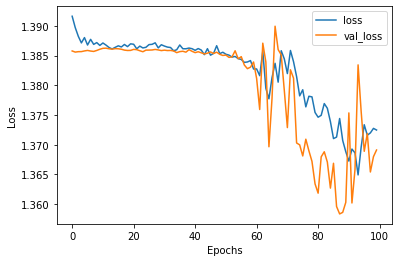

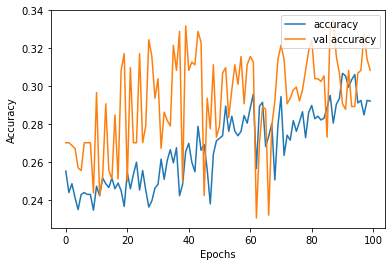

In [15]:
plot_learning_curve(history)

In [16]:
def prediction(model,tokenizer,input_string):
    
    padded_tokens = tokenizer(
    text=[input_string],
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
    
    my_prediction = model.predict(padded_tokens['input_ids'])
    print(my_prediction)
    conversion_dict = {0:'joy',1:'fear',2:'anger',3:'sadness'}
    
    return conversion_dict[np.argmax(my_prediction)]

In [17]:
# I am feeling scared
#prediction(model,tokenizer,"मुझे डर लग रहा है")

In [18]:
# I like bass
#prediction(model,tokenizer,"J'aime la basse")

In [19]:
#I am going to fail 我会失败
#prediction(model,tokenizer,"我会失败")

In [20]:
# My mother was killed
#prediction(model,tokenizer,"मेरी मां को मार दिया गया")

In [21]:
#model.evaluate(x=xtest_pad['input_ids'],y=ytest)

In [22]:
#xtest_pad['input_ids']